## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

# 參數沿用前面最佳結果
L1_L2_RATIO = 1e-12
OUTPUT_UNITS = 10
NUM_NEURONS = [512, 256, 128]
DRP_RATIO = 0.25

WAITTING = [5, 10, 25]

In [6]:
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2
from keras.layers import Dropout

"""
建立神經網路，並加入 BN layer, regularizer, Dropout
"""
def build_mlp(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(NUM_NEURONS):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            # 加入 BN layer
            x = BatchNormalization()(x)
            # 加入 regularizer
            x = keras.layers.Dense(units=n_units, kernel_regularizer=l1_l2(L1_L2_RATIO))(x)
            # 加入 Dropout
            x = Dropout(DRP_RATIO)(x)
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            # 加入 BN layer
            x = BatchNormalization()(x)
            # 加入 regularizer
            x = keras.layers.Dense(units=n_units, kernel_regularizer=l1_l2(L1_L2_RATIO))(x)
            # 加入  Dropout
            x = Dropout(DRP_RATIO)(x)
    
    out = keras.layers.Dense(units=OUTPUT_UNITS, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
from keras.callbacks import EarlyStopping


def Training_Model(monitor_str, results):
    for wait in WAITTING:
        model = build_mlp(x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        
        earlystop = EarlyStopping(monitor = monitor_str, 
                                  patience = wait, 
                                  verbose = 1)
        model.fit(
                  x_train, y_train,
                  epochs=EPOCHS, 
                  batch_size= BATCH_SIZE,
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[earlystop]
                 )
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "Waitting Time %s" % str(wait)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def Draw_Result(monitor_str, results):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
  
    plt.title(monitor_str + " Loss")
    plt.ylim([0, 20])
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title(monitor_str + " Accuracy")
    plt.legend()
    plt.show()

In [9]:
results_valloss = {}
Training_Model( "val_loss", results_valloss)

W0720 12:14:00.322099 15444 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 12:14:00.334040 15444 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 12:14:00.335064 15444 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 12:14:00.387434 15444 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 12:14:00.413337 15444 deprecation.py:506] From D:\Anaconda3\lib\site-packages\keras\back

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 4s 89us/step - loss: 2.7493 - acc: 0.6001 - val_loss: 2.9340 - val_acc: 0.5312
Epoch 45/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.6741 - acc: 0.6049 - val_loss: 2.8811 - val_acc: 0.5286
Epoch 46/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.6029 - acc: 0.6087 - val_loss: 2.8142 - val_acc: 0.5285
Epoch 47/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.5356 - acc: 0.6133 - val_loss: 2.7545 - val_acc: 0.5335
Epoch 48/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.4699 - acc: 0.6159 - val_loss: 2.7260 - val_acc: 0.5234
Epoch 49/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.4018 - acc: 0.6237 - val_loss: 2.6633 - val_acc: 0.5302
Epoch 50/50
50000/50000 [==============================] - 4s 87us/step - loss: 2.3373 - acc: 0.6273 - val_loss: 2.6148 - val_acc: 0.5342
______________________________________________

50000/50000 [==============================] - 4s 90us/step - loss: 3.3433 - acc: 0.5695 - val_loss: 3.4518 - val_acc: 0.5145
Epoch 38/50
50000/50000 [==============================] - 4s 88us/step - loss: 3.2517 - acc: 0.5737 - val_loss: 3.3626 - val_acc: 0.5208
Epoch 39/50
50000/50000 [==============================] - 5s 92us/step - loss: 3.1618 - acc: 0.5773 - val_loss: 3.2827 - val_acc: 0.5199
Epoch 40/50
50000/50000 [==============================] - 5s 92us/step - loss: 3.0734 - acc: 0.5830 - val_loss: 3.2486 - val_acc: 0.5112
Epoch 41/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.9834 - acc: 0.5889 - val_loss: 3.1347 - val_acc: 0.5256
Epoch 42/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.9077 - acc: 0.5923 - val_loss: 3.1359 - val_acc: 0.5068
Epoch 43/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.8295 - acc: 0.5930 - val_loss: 3.0099 - val_acc: 0.5221
Epoch 44/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 90us/step - loss: 4.1051 - acc: 0.5377 - val_loss: 4.1135 - val_acc: 0.5159
Epoch 31/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.9822 - acc: 0.5455 - val_loss: 4.0054 - val_acc: 0.5158
Epoch 32/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.8653 - acc: 0.5497 - val_loss: 3.9116 - val_acc: 0.5125
Epoch 33/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.7554 - acc: 0.5527 - val_loss: 3.7962 - val_acc: 0.5183
Epoch 34/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.6490 - acc: 0.5557 - val_loss: 3.6976 - val_acc: 0.5192
Epoch 35/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.5436 - acc: 0.5621 - val_loss: 3.6060 - val_acc: 0.5197
Epoch 36/50
50000/50000 [==============================] - 5s 90us/step - loss: 3.4403 - acc: 0.5635 - val_loss: 3.5254 - val_acc: 0.5170
Epoch 37/50
50000/50000 [=====================

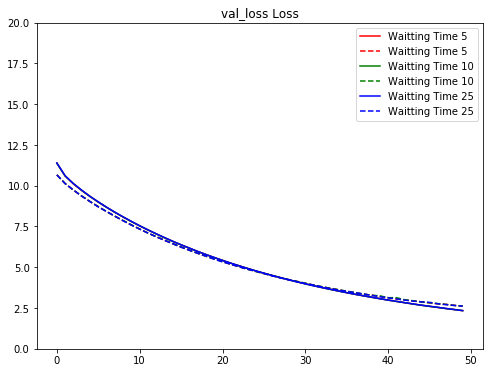

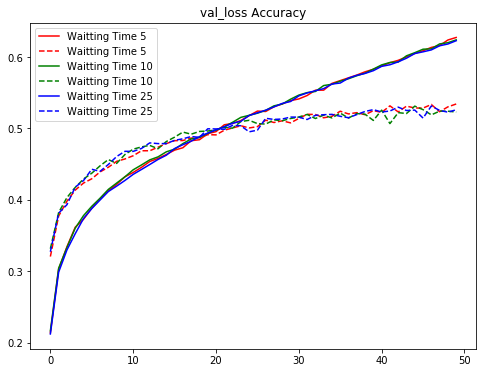

In [18]:
Draw_Result("val_loss", results_valloss)

In [15]:
results_valacc = {}
Training_Model( "val_acc", results_valacc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
__________

50000/50000 [==============================] - 4s 89us/step - loss: 2.7539 - acc: 0.6028 - val_loss: 2.9681 - val_acc: 0.5174
Epoch 45/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.6779 - acc: 0.6081 - val_loss: 2.8880 - val_acc: 0.5271
Epoch 46/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.6080 - acc: 0.6118 - val_loss: 2.8600 - val_acc: 0.5211
Epoch 47/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.5384 - acc: 0.6166 - val_loss: 2.7863 - val_acc: 0.5234
Epoch 48/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4676 - acc: 0.6218 - val_loss: 2.7489 - val_acc: 0.5192
Epoch 49/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.4025 - acc: 0.6241 - val_loss: 2.6894 - val_acc: 0.5232
Epoch 50/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.3376 - acc: 0.6306 - val_loss: 2.6634 - val_acc: 0.5159
Epoch 00050: early stopping
__________________

50000/50000 [==============================] - 4s 89us/step - loss: 3.3510 - acc: 0.5720 - val_loss: 3.4708 - val_acc: 0.5102
Epoch 38/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.2530 - acc: 0.5777 - val_loss: 3.3670 - val_acc: 0.5202
Epoch 39/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.1685 - acc: 0.5785 - val_loss: 3.3054 - val_acc: 0.5182
Epoch 40/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.0798 - acc: 0.5839 - val_loss: 3.2386 - val_acc: 0.5184
Epoch 41/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.9930 - acc: 0.5900 - val_loss: 3.1409 - val_acc: 0.5276
Epoch 42/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.9108 - acc: 0.5931 - val_loss: 3.0762 - val_acc: 0.5249
Epoch 43/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.8324 - acc: 0.5976 - val_loss: 3.0100 - val_acc: 0.5210
Epoch 44/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 89us/step - loss: 4.1002 - acc: 0.5410 - val_loss: 4.1150 - val_acc: 0.5153
Epoch 31/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.9760 - acc: 0.5475 - val_loss: 4.0062 - val_acc: 0.5154
Epoch 32/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.8627 - acc: 0.5474 - val_loss: 3.9017 - val_acc: 0.5193
Epoch 33/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.7482 - acc: 0.5540 - val_loss: 3.8097 - val_acc: 0.5178
Epoch 34/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.6434 - acc: 0.5568 - val_loss: 3.6987 - val_acc: 0.5257
Epoch 35/50
50000/50000 [==============================] - 5s 91us/step - loss: 3.5361 - acc: 0.5646 - val_loss: 3.6156 - val_acc: 0.5218
Epoch 36/50
50000/50000 [==============================] - 5s 91us/step - loss: 3.4368 - acc: 0.5676 - val_loss: 3.5257 - val_acc: 0.5243
Epoch 37/50
50000/50000 [=====================

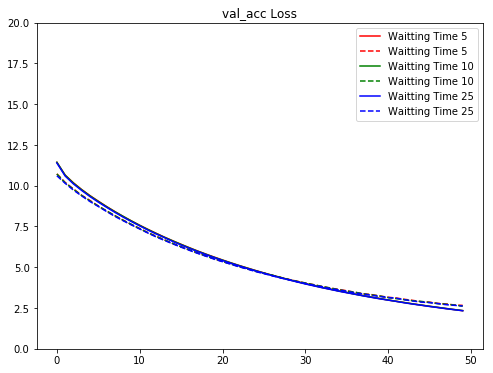

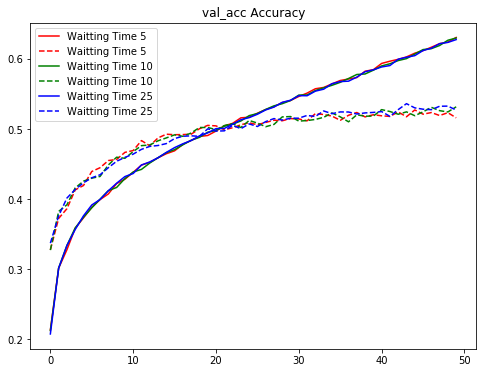

In [19]:
Draw_Result("val_acc", results_valacc)

In [20]:
results_loss = {}
Training_Model( "loss", results_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
__________

50000/50000 [==============================] - 4s 88us/step - loss: 2.7385 - acc: 0.6074 - val_loss: 2.9393 - val_acc: 0.5280
Epoch 45/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.6635 - acc: 0.6113 - val_loss: 2.8653 - val_acc: 0.5370
Epoch 46/50
50000/50000 [==============================] - 4s 90us/step - loss: 2.5883 - acc: 0.6161 - val_loss: 2.8285 - val_acc: 0.5255
Epoch 47/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.5212 - acc: 0.6201 - val_loss: 2.7668 - val_acc: 0.5262
Epoch 48/50
50000/50000 [==============================] - 5s 90us/step - loss: 2.4507 - acc: 0.6262 - val_loss: 2.7193 - val_acc: 0.5274
Epoch 49/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.3873 - acc: 0.6306 - val_loss: 2.6567 - val_acc: 0.5316
Epoch 50/50
50000/50000 [==============================] - 4s 88us/step - loss: 2.3193 - acc: 0.6343 - val_loss: 2.6173 - val_acc: 0.5277
______________________________________________

50000/50000 [==============================] - 5s 91us/step - loss: 3.3373 - acc: 0.5738 - val_loss: 3.4655 - val_acc: 0.5194
Epoch 38/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.2388 - acc: 0.5799 - val_loss: 3.3552 - val_acc: 0.5270
Epoch 39/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.1493 - acc: 0.5846 - val_loss: 3.2841 - val_acc: 0.5291
Epoch 40/50
50000/50000 [==============================] - 4s 89us/step - loss: 3.0644 - acc: 0.5866 - val_loss: 3.2081 - val_acc: 0.5272
Epoch 41/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.9811 - acc: 0.5916 - val_loss: 3.1487 - val_acc: 0.5210
Epoch 42/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.8987 - acc: 0.5957 - val_loss: 3.0624 - val_acc: 0.5296
Epoch 43/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.8132 - acc: 0.6025 - val_loss: 3.0146 - val_acc: 0.5268
Epoch 44/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 89us/step - loss: 4.1130 - acc: 0.5374 - val_loss: 4.1241 - val_acc: 0.5117
Epoch 31/50
50000/50000 [==============================] - 4s 88us/step - loss: 3.9848 - acc: 0.5457 - val_loss: 4.0096 - val_acc: 0.5138
Epoch 32/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.8723 - acc: 0.5481 - val_loss: 3.9147 - val_acc: 0.5144
Epoch 33/50
50000/50000 [==============================] - 4s 90us/step - loss: 3.7598 - acc: 0.5514 - val_loss: 3.7983 - val_acc: 0.5186
Epoch 34/50
50000/50000 [==============================] - 4s 88us/step - loss: 3.6524 - acc: 0.5556 - val_loss: 3.7057 - val_acc: 0.5184
Epoch 35/50
50000/50000 [==============================] - 4s 88us/step - loss: 3.5450 - acc: 0.5612 - val_loss: 3.6080 - val_acc: 0.5206
Epoch 36/50
50000/50000 [==============================] - 4s 88us/step - loss: 3.4429 - acc: 0.5654 - val_loss: 3.5425 - val_acc: 0.5156
Epoch 37/50
50000/50000 [=====================

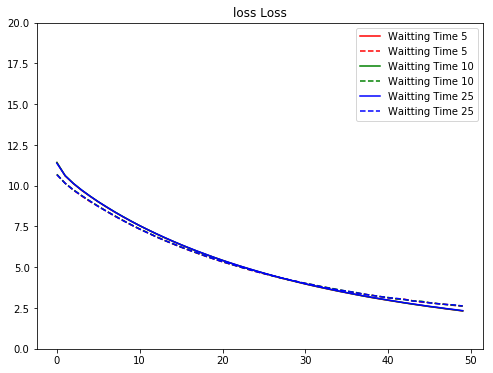

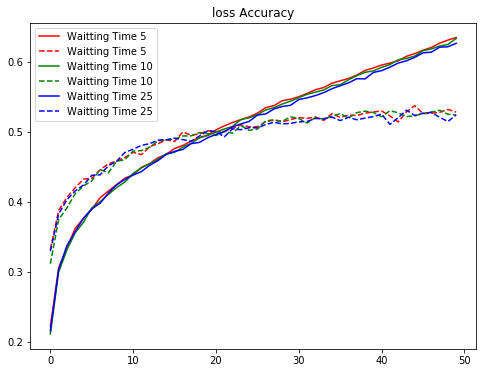

In [21]:
Draw_Result("loss", results_loss)

In [22]:
results_acc = {}
Training_Model( "acc", results_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
__________

50000/50000 [==============================] - 5s 90us/step - loss: 2.7493 - acc: 0.6012 - val_loss: 2.9419 - val_acc: 0.5258
Epoch 45/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.6758 - acc: 0.6025 - val_loss: 2.8855 - val_acc: 0.5255
Epoch 46/50
50000/50000 [==============================] - 4s 90us/step - loss: 2.5973 - acc: 0.6107 - val_loss: 2.8429 - val_acc: 0.5204
Epoch 47/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.5279 - acc: 0.6144 - val_loss: 2.7673 - val_acc: 0.5261
Epoch 48/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4641 - acc: 0.6166 - val_loss: 2.7272 - val_acc: 0.5316
Epoch 49/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.4003 - acc: 0.6227 - val_loss: 2.6763 - val_acc: 0.5208
Epoch 50/50
50000/50000 [==============================] - 5s 90us/step - loss: 2.3384 - acc: 0.6286 - val_loss: 2.6186 - val_acc: 0.5303
______________________________________________

50000/50000 [==============================] - 5s 94us/step - loss: 3.3439 - acc: 0.5705 - val_loss: 3.4658 - val_acc: 0.5155
Epoch 38/50
50000/50000 [==============================] - 5s 94us/step - loss: 3.2465 - acc: 0.5748 - val_loss: 3.3732 - val_acc: 0.5192
Epoch 39/50
50000/50000 [==============================] - 5s 92us/step - loss: 3.1574 - acc: 0.5810 - val_loss: 3.2844 - val_acc: 0.5258
Epoch 40/50
50000/50000 [==============================] - 5s 98us/step - loss: 3.0696 - acc: 0.5846 - val_loss: 3.2265 - val_acc: 0.5157
Epoch 41/50
50000/50000 [==============================] - 5s 96us/step - loss: 2.9860 - acc: 0.5876 - val_loss: 3.1530 - val_acc: 0.5181
Epoch 42/50
50000/50000 [==============================] - 5s 93us/step - loss: 2.9076 - acc: 0.5904 - val_loss: 3.0944 - val_acc: 0.5186
Epoch 43/50
50000/50000 [==============================] - 5s 93us/step - loss: 2.8262 - acc: 0.5974 - val_loss: 2.9971 - val_acc: 0.5276
Epoch 44/50
50000/50000 [=====================

50000/50000 [==============================] - 5s 94us/step - loss: 4.1007 - acc: 0.5407 - val_loss: 4.1210 - val_acc: 0.5134
Epoch 31/50
50000/50000 [==============================] - 5s 94us/step - loss: 3.9821 - acc: 0.5439 - val_loss: 3.9989 - val_acc: 0.5217
Epoch 32/50
50000/50000 [==============================] - 5s 95us/step - loss: 3.8620 - acc: 0.5491 - val_loss: 3.9079 - val_acc: 0.5126
Epoch 33/50
50000/50000 [==============================] - 5s 95us/step - loss: 3.7475 - acc: 0.5554 - val_loss: 3.8180 - val_acc: 0.5143
Epoch 34/50
50000/50000 [==============================] - 5s 95us/step - loss: 3.6413 - acc: 0.5557 - val_loss: 3.7048 - val_acc: 0.5199
Epoch 35/50
50000/50000 [==============================] - 5s 95us/step - loss: 3.5377 - acc: 0.5606 - val_loss: 3.6132 - val_acc: 0.5203
Epoch 36/50
50000/50000 [==============================] - 5s 94us/step - loss: 3.4353 - acc: 0.5662 - val_loss: 3.5192 - val_acc: 0.5242
Epoch 37/50
50000/50000 [=====================

In [ ]:
Draw_Result("acc", results_acc)